In [1]:
# example codes from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
# Untargeted FGSM attack

# import using packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
# setting parameters & model
epsilon = 25 / 255
alpha = 10 / 255
max_iter = 15
pretrained_model = "../data/lenet_mnist_model.pth"
use_cuda=True
# Set random seed for reproducibility
torch.manual_seed(42)

In [3]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=1, shuffle=False)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location=device))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [4]:
# targeted FGSM attack
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image - epsilon * sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

# targeted PGD attack
def pgd_attack(model, data, data_denorm, alpha, max_iter, target, epsilon):
    # initialize perturbed image
    perturbed_image = data_denorm
    original_image = data_denorm

    data, target = data.to(device), target.to(device)
    original_image = original_image.to(device)
    data.requires_grad = True

    # iterate for max_iter
    for iter in range(max_iter):
        output = model(data)
        new_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if new_pred.item() == target.item():
            break
        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data

        data_denorm = denorm(data)
        perturbed_image = fgsm_attack(data_denorm, alpha, data_grad)
        perturbed_image = perturbed_image.to(device)

        # Clip perturbations to epsilon
        perturbed_image = torch.clamp(perturbed_image, original_image - epsilon, original_image + epsilon)

        # change data value as normalized perturbed image
        data = norm(perturbed_image).clone().detach().requires_grad_(True)
        
    data_denorm = denorm(data)
    return data_denorm

# Denormalize function
# also from example code
# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

# Normalize function
def norm(batch, mean=[0.1307], std=[0.3081]):
    return transforms.Normalize((mean,), (std,))(batch)

In [5]:
# test function
# it performs targetted FGSM attack & PGD attack
# compare two results

def test( model, device, test_loader, alpha, max_iter, epsilon ):
	# Accuracy counter
	correct = {
		'fgsm': 0,
		'pgd': 0
	}
	adv_examples = {
		'fgsm': [],
		'pgd': []
	}
	cnt = 0
	limit = 1000

	# Loop over all examples in test set
	for data, target in test_loader:
		
		# Send the data and label to the device
		available_targets = [i for i in range(10) if i != target.item()]
		attack_target = torch.tensor([random.choice(available_targets)])
		data, attack_target = data.to(device), attack_target.to(device)
		target = target.to(device)

		# Set requires_grad attribute of tensor. Important for FGSM Attack
		data.requires_grad = True

		# Forward pass the data through the model
		output = model(data)
		init_pred = output.max(1, keepdim=True)[1]

		# If the initial prediction is wrong, dont bother attacking, just move on
		if init_pred.item() != target.item():
			continue
		cnt += 1

		# Calculate the loss
		loss = F.nll_loss(output, attack_target)

    # Zero all existing gradients
		model.zero_grad()

    # Calculate gradients of model in backward pass
		loss.backward()

		# Collect ``datagrad``
		data_grad = data.grad.data

		# Restore the data to its original scale
		data_denorm = denorm(data)

    # Call FGSM Attack
		fgsm_perturbed = fgsm_attack(data_denorm, epsilon, data_grad)

		# Call PGD Attack
		pgd_perturbed = pgd_attack(model, data, data_denorm, alpha, max_iter, attack_target, epsilon)

		# Reapply normalization
		fgsm_perturbed_normalized = transforms.Normalize((0.1307,), (0.3081,))(fgsm_perturbed)
		pgd_perturbed_normalized = transforms.Normalize((0.1307,), (0.3081,))(pgd_perturbed)

		# Re-classify the perturbed image & Check for success
		fgsm_output = model(fgsm_perturbed_normalized)
		fgsm_pred = fgsm_output.max(1, keepdim=True)[1] # get the index of the max log-probability
		if fgsm_pred.item() == attack_target.item():
			correct['fgsm'] += 1
			# Special case for saving 0 epsilon examples
			if len(adv_examples['fgsm']) < 5:
				adv_ex = fgsm_perturbed.squeeze().detach().cpu().numpy()
				adv_examples['fgsm'].append( (init_pred.item(), attack_target.item(), adv_ex) )

		pgd_output = model(pgd_perturbed_normalized)
		pgd_pred = pgd_output.max(1, keepdim=True)[1] # get the index of the max log-probability
		if pgd_pred.item() == attack_target.item():
			correct['pgd'] += 1
			if len(adv_examples['pgd']) < 5:
				adv_ex = pgd_perturbed.squeeze().detach().cpu().numpy()
				adv_examples['pgd'].append( (init_pred.item(), attack_target.item(), adv_ex) )

		# only test 1000 examples (for time issue)
		if cnt > limit:
			break

	# Calculate final accuracy for this epsilon
	final_acc = {
		'fgsm': correct['fgsm'] / float(cnt),
		'pgd': correct['pgd'] / float(cnt)
	}
	print("Epsilon: {}/255, Alpha: {}/255\nFGSM Attack Accuracy =\t{} / {} = {}\nPGD Attack Accuracy =\t{} / {} = {}\n".format(int(epsilon*255), int(alpha*255), correct['fgsm'], limit, final_acc['fgsm'], correct['pgd'], limit, final_acc['pgd']))

	# Return the accuracy and an adversarial example
	return final_acc, adv_examples


In [6]:
# Run test
acc, ex = test(model, device, test_loader, alpha, max_iter, epsilon)
fgsm_example = ex['fgsm']
pgd_example = ex['pgd']

Epsilon: 25/255, Alpha: 10/255
FGSM Attack Accuracy =	25 / 1000 = 0.024975024975024976
PGD Attack Accuracy =	94 / 1000 = 0.0939060939060939



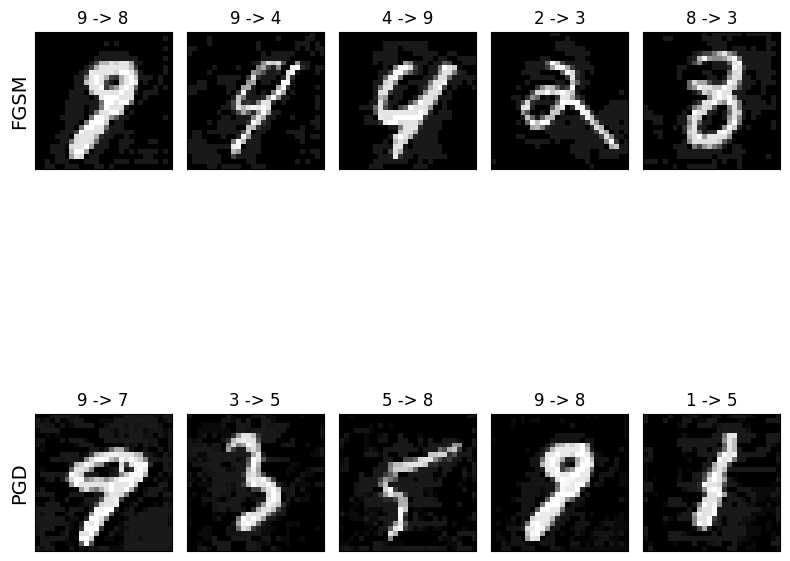

In [7]:
# Plot several examples of adversarial samples at each attack
# each row represents each attack
# 5 examples are shown for each attack
plt.figure(figsize=(8,10))
for i in range(len(fgsm_example)):
    plt.subplot(2,5,i+1)
    plt.xticks([], [])
    plt.yticks([], [])
    if i == 0:
        plt.ylabel("FGSM", fontsize=14)
    orig, adv, ex = fgsm_example[i]
    plt.title("{} -> {}".format(orig, adv))
    plt.imshow(ex, cmap="gray")
for i in range(len(pgd_example)):
    plt.subplot(2,5,5+i+1)
    plt.xticks([], [])
    plt.yticks([], [])
    if i == 0:
        plt.ylabel("PGD", fontsize=14)
    orig, adv, ex = pgd_example[i]
    plt.title("{} -> {}".format(orig, adv))
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()
